<!DOCTYPE html>
<html>
<head>
    <title>Smartphone Prediction</title>
</head>
<body>
    <center><h2><b>Smartphone Prediction</b></h2></center>
</body>
</html>
<div style="display: flex; justify-content: center;">
    <img src="https://www.zdnet.com/a/img/resize/8b5a12b9b5fd58fd1943604699993f1e6469be19/2023/08/22/71f6e0b9-3405-43ea-972c-202a7c8bf615/best-phones-zdnet-thumb-image.jpg?auto=webp&fit=crop&height=675&width=1200" style="border-radius: 20px;">
</div></div>



# **1. Import Main Modules**

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# **2. Applying Simple Analysis**

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

def wrangle_smartphone_data(csv_file):
    # Step 1: Read the CSV file
    smartphone = pd.read_csv(csv_file)
    
    # Step 2: Check for NaN values
    nan_values = smartphone.isnull().sum()
    missing_percentage = (nan_values / len(smartphone)) * 100
    missing_data = pd.DataFrame({
        'Missing Values': nan_values,
        'Percentage': missing_percentage
    })

    print("\n" + "="*30 + " Missing Values Percentage " + "="*30)
    print(tabulate(missing_data, headers='keys', tablefmt='pretty'))
    
    # Step 3: Fill NA values with the nearest value of the same model
    smartphone = smartphone.groupby('model').apply(lambda group: group.fillna(method='bfill').fillna(method='ffill')).reset_index(drop=True)
    print("\n" + "="*30 + " Missing Values Filled " + "="*30)
    print("NA values filled with the nearest value of the same model.")
    
    # Step 4: Drop 'model' column
    smartphone = smartphone.drop(columns=['model'])
    
    # Step 5: Forward fill remaining missing values
    smartphone = smartphone.fillna(method='ffill')
    print("\n" + "="*30 + " Missing Values Filled " + "="*30)
    print("NA values filled with the forward fill method.")
    
    # Step 6: Drop rows with any remaining NaN values
    smartphone = smartphone.dropna()
    
    # Step 7: Statistical summaries
    description = smartphone.describe()
    print("\n" + "="*30 + " Data Description " + "="*30)
    print(description)

    # Return or print cleaned DataFrame
    return smartphone


csv_file = 'Smartphones.csv'
smartphone = wrangle_smartphone_data(csv_file)
print("\nCleaned Smartphone Data:")
print(smartphone)


============================== Missing Values Percentage ==============================
+---------------------------+----------------+---------------------+
|                           | Missing Values |     Percentage      |
+---------------------------+----------------+---------------------+
|        brand_name         |      0.0       |         0.0         |
|           model           |      0.0       |         0.0         |
|           price           |      0.0       |         0.0         |
|          rating           |     101.0      | 10.306122448979592  |
|          has_5g           |      0.0       |         0.0         |
|          has_nfc          |      0.0       |         0.0         |
|      has_ir_blaster       |      0.0       |         0.0         |
|      processor_brand      |      20.0      | 2.0408163265306123  |
|         num_cores         |      6.0       | 0.6122448979591837  |
|      processor_speed      |      42.0      |  4.285714285714286  |
|     battery_

In [89]:
smartphone.head()

,brand_name,price,rating,has_5g,has_nfc,has_ir_blaster,processor_brand,num_cores,processor_speed,battery_capacity,...,refresh_rate,num_rear_cameras,num_front_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,extended_upto,resolution_width,resolution_height
56,cola,14999,74.0,False,False,False,helio,8.0,2.20,5000.0,...,90,2,1.0,android,50.0,16.0,1,1024.0,1080,2400
57,doogee,14999,84.0,False,True,False,helio,8.0,2.05,6000.0,...,60,3,1.0,android,108.0,32.0,1,1024.0,1080,2340
58,doogee,45999,88.0,True,False,False,dimensity,8.0,2.60,22000.0,...,120,3,1.0,android,108.0,32.0,1,2048.0,1080,2408
59,duoqin,9990,88.0,False,False,False,helio,8.0,2.00,2150.0,...,60,1,1.0,android,8.0,2.0,1,2048.0,640,960
60,gionee,6190,88.0,False,False,False,tiger,4.0,2.00,3500.0,...,60,2,1.0,other,13.0,5.0,1,2048.0,720,1600


# **3.Apply Important Vizs on data**

#### 3.1 let's check brand with highest prices

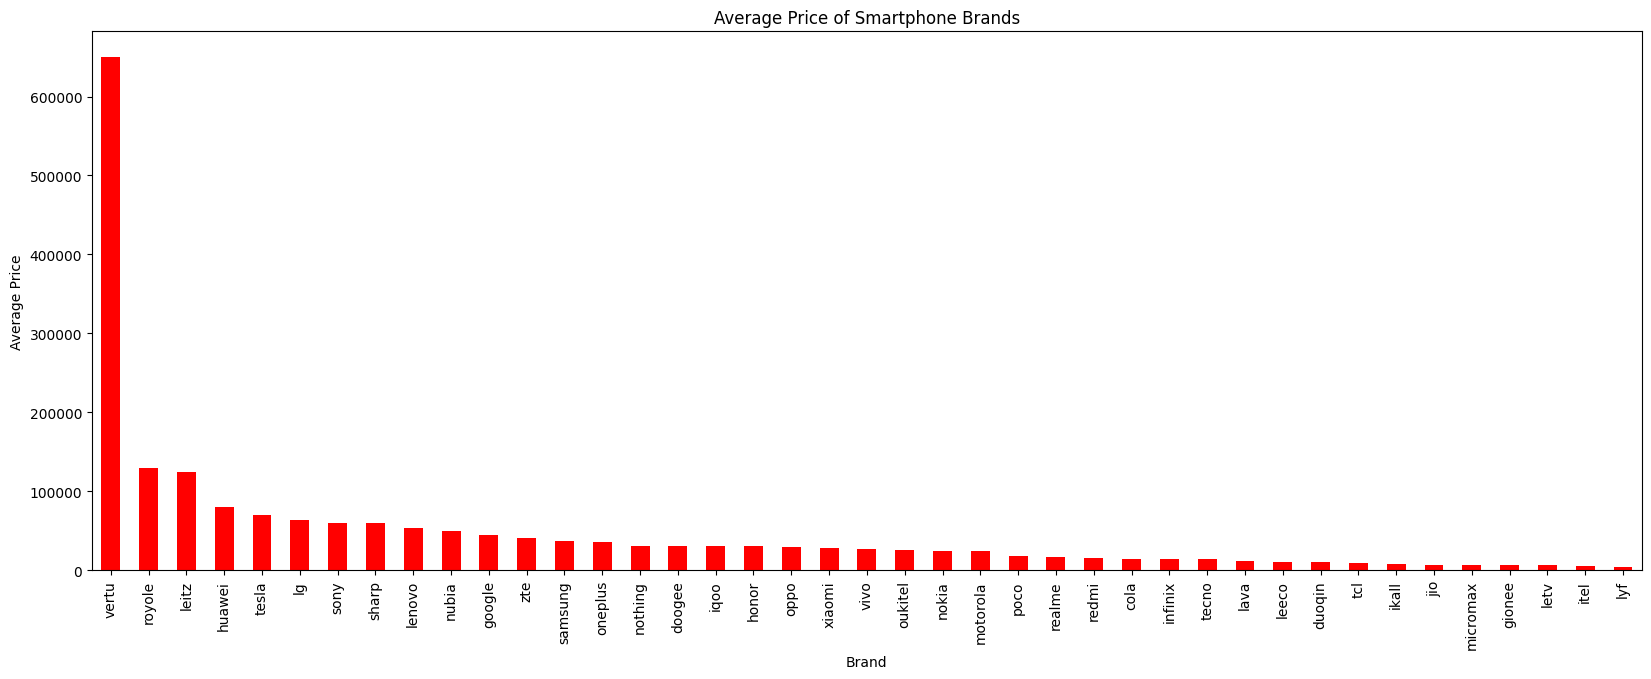

In [90]:
# Plotting the brand with highest average price
plt.figure(figsize=(20, 7))
brand_avg_price = smartphone.groupby('brand_name')['price'].mean().sort_values(ascending=False)
brand_avg_price.plot(kind='bar', color='red')
plt.title('Average Price of Smartphone Brands')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.show()


<H3><p align="center">Like Wow, there's something much more expensive than apple <strong>O_O</strong></p></H3>

#### 3.2 Does price follows Normal Distribution?

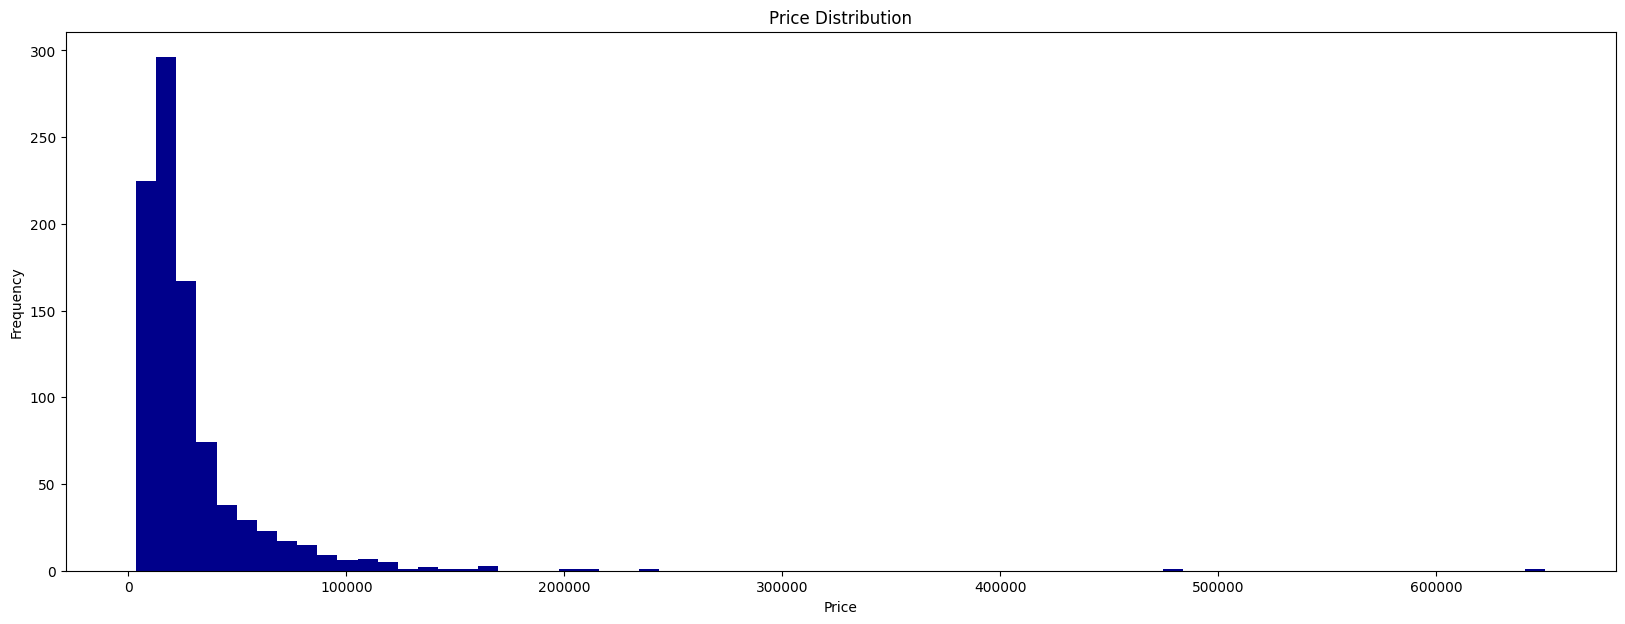

In [91]:
# Checking of normality of the price column
plt.figure(figsize=(20, 7))
smartphone['price'].plot(kind='hist', color='darkblue',bins=70)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


##### 3.2.1 Fixing the normality of the price column

The Box-Cox transformation formula:

\begin{cases}
    \frac{y^\lambda - 1}{\lambda}, & \text{if } \lambda \neq 0 \\
    \ln(y), & \text{if } \lambda = 0
\end{cases}

<p>
    When determining the optimal λ for data transformation, different approaches are used depending on the nature of the data. For classification tasks (where yi=0), a common transformation involves applying ln(y) to the data. For continuous variables like prices, the Box-Cox transformation formula is typically used, adjusting the data to achieve normality.
</p>
<p>
    The optimal λ is found by evaluating the transformed data across various λ values and selecting the one that maximizes normality. This process often involves statistical tests or visual inspections to ensure the transformed data meets the desired criteria for analysis.
</p>



Box-Cox Lambda Value: -0.2849905135279127


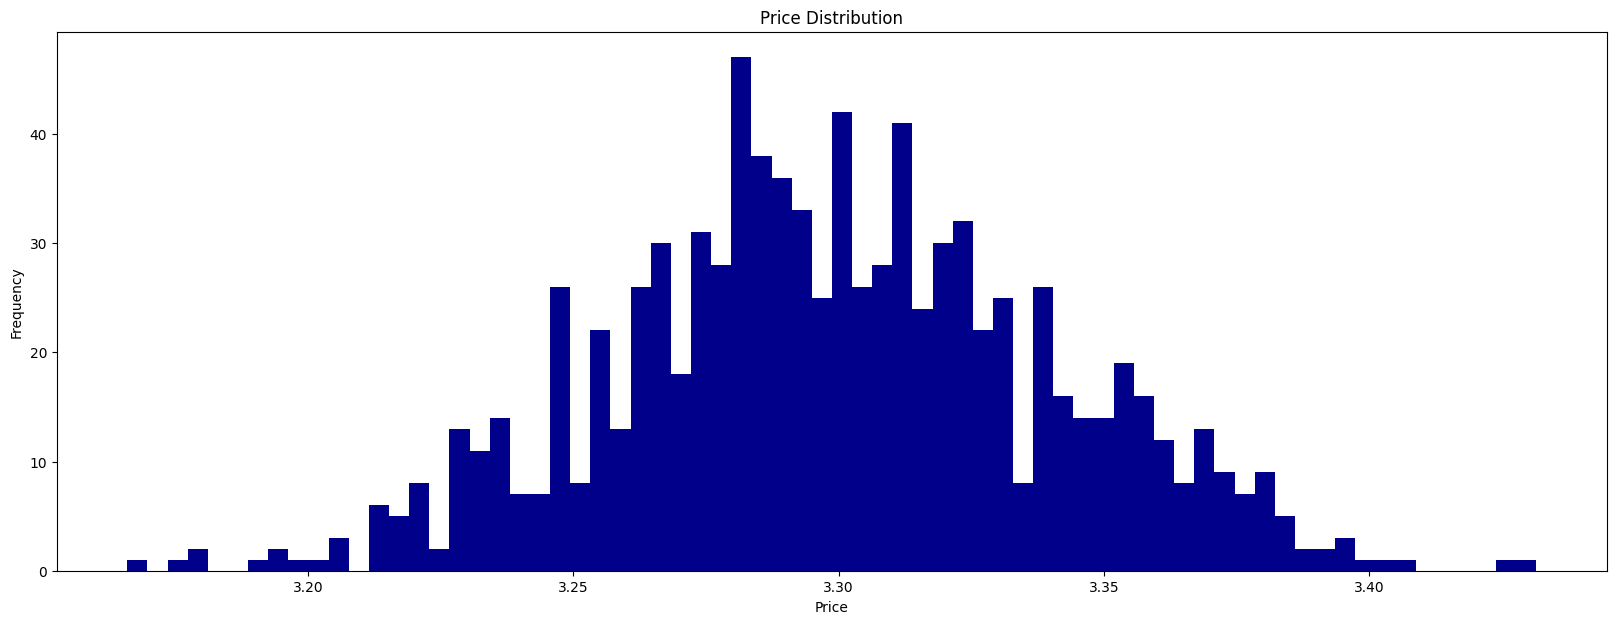

In [92]:
# Apply Box-Cox transformation to the price column
smartphone['price'], price_lambda = boxcox(smartphone['price'])
print("\nBox-Cox Lambda Value:", price_lambda)
# Plot again
plt.figure(figsize=(20, 7))
smartphone['price'].plot(kind='hist', color='darkblue', bins=70)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [93]:
smartphone.price

56     3.282408
57     3.282408
58     3.344326
59     3.254598
60     3.217432
         ...   
975    3.214691
976    3.227355
977    3.213276
978    3.223923
979    3.211757
Name: price, Length: 924, dtype: float64

#### 3.3 What about checking Processor speed with cores?

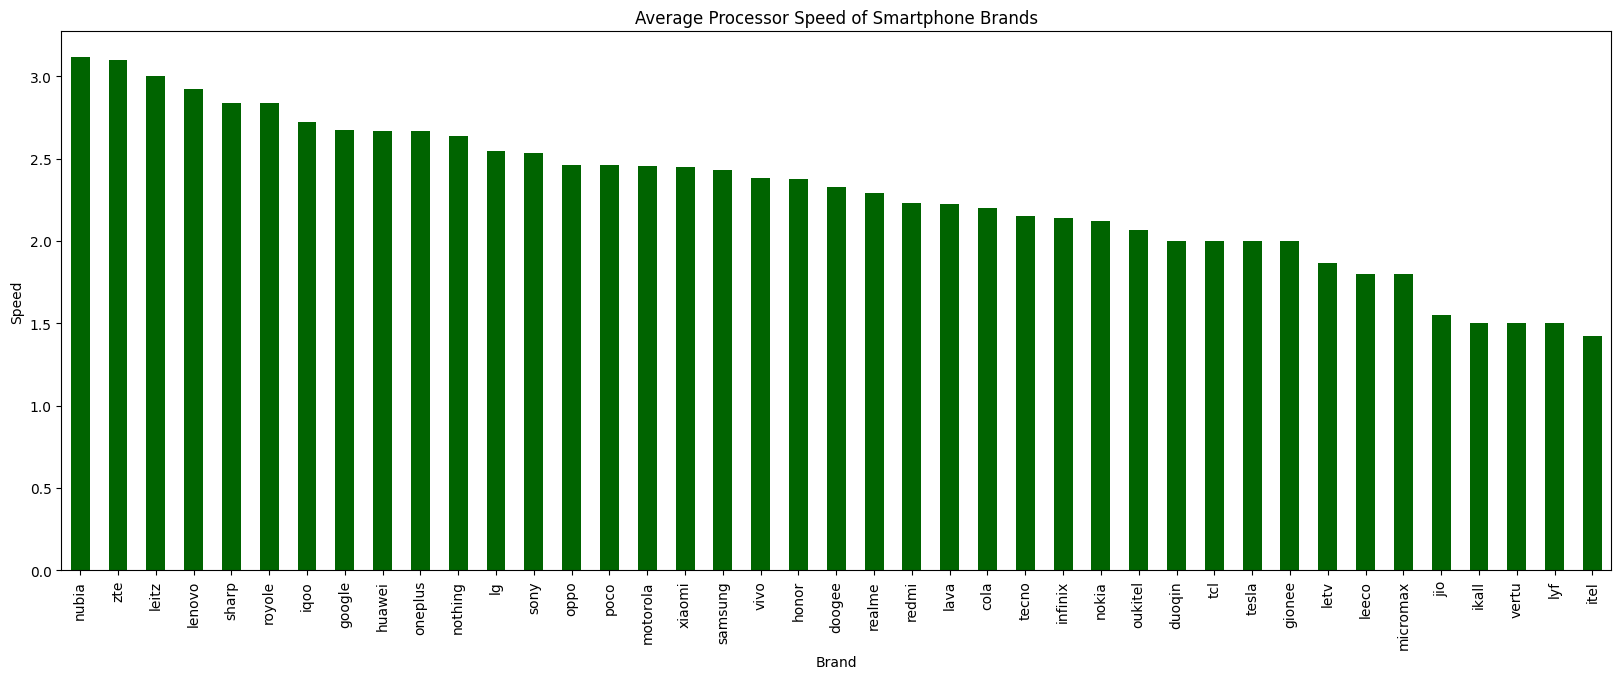

In [94]:
# Which phone has highest processor speed
plt.figure(figsize=(20, 7))
brand_avg_price = smartphone.groupby('brand_name')['processor_speed'].mean().sort_values(ascending=False)
brand_avg_price.plot(kind='bar', color='darkgreen')
plt.title('Average Processor Speed of Smartphone Brands')
plt.xlabel('Brand')
plt.ylabel('Speed')
plt.show()


<H3><p align="center">As usual Asus processors are the most speed one, but what about cores?</p></H3>

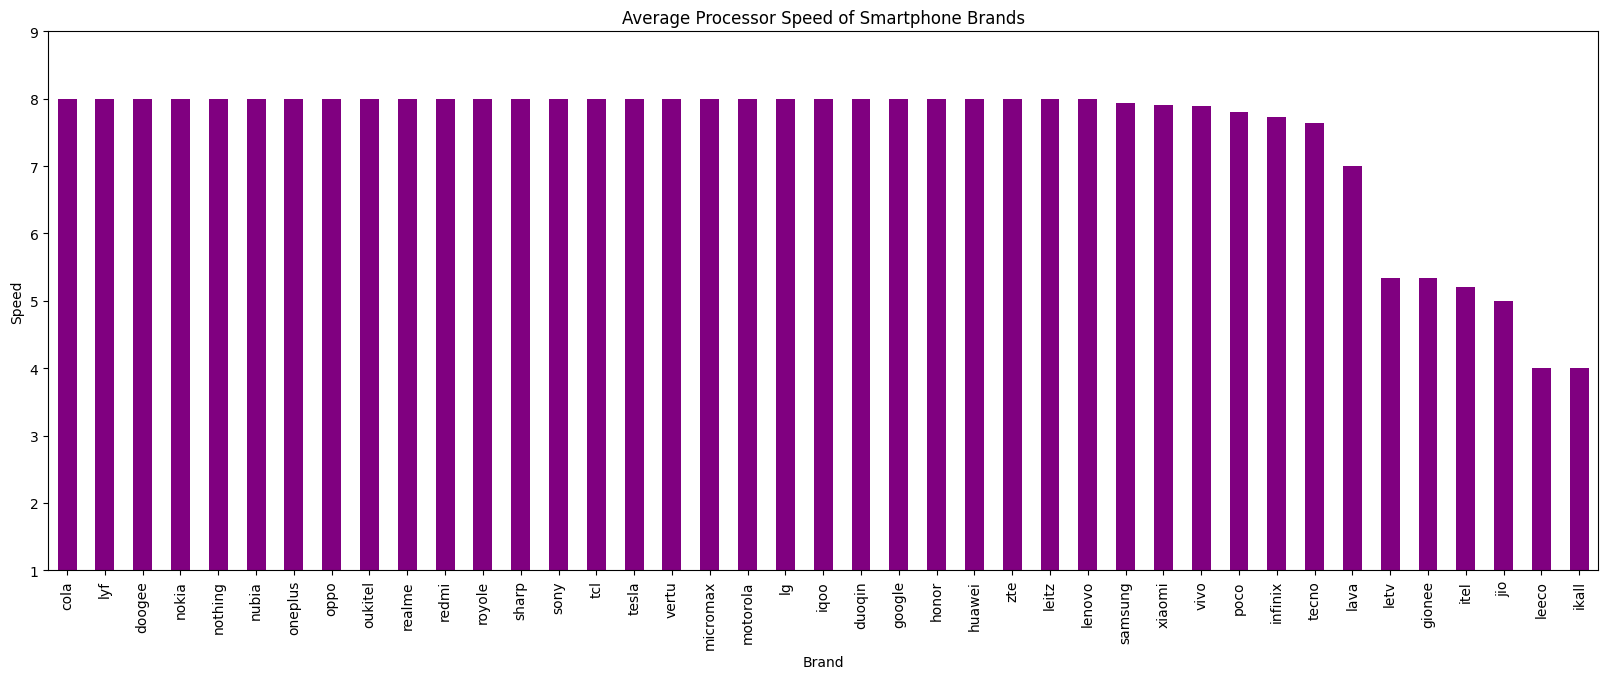

In [95]:
# Which phone has highest processor speed
plt.figure(figsize=(20, 7))
brand_avg_price = smartphone.groupby('brand_name')['num_cores'].mean().sort_values(ascending=False)
brand_avg_price.plot(kind='bar', color='purple')
plt.title('Average Processor Speed of Smartphone Brands')
plt.xlabel('Brand')
plt.ylim((1,9))
plt.ylabel('Speed')
plt.show()

<H3><p align="center">Ok not big deal, like 60-65% are 8 cores</p></H3>

#### 3.4 Which one has highest memory?

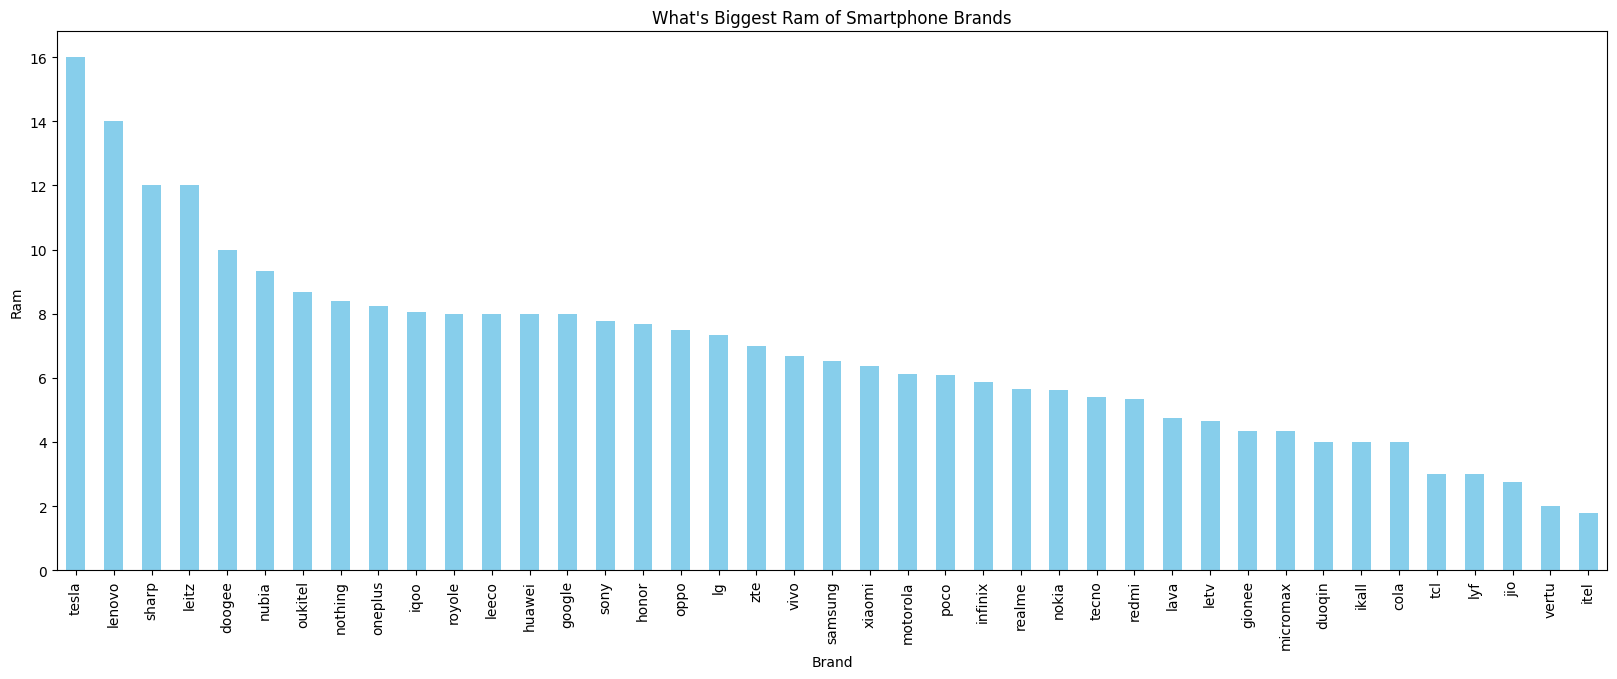

In [96]:
Biggest_Ram = smartphone.groupby('brand_name')['ram_capacity'].mean().sort_values(ascending=False)
plt.figure(figsize=(20, 7))
Biggest_Ram.plot(kind='bar', color='skyblue')
plt.title('What\'s Biggest Ram of Smartphone Brands')
plt.xlabel('Brand')
plt.ylabel('Ram')
plt.show()

<H3><p align="center">I love tesla anyway</p></H3>

# **4. Building Model!**

<H3><p align="center">Our target here is price, so let's focus on it</p></H3>

In [97]:
# Seprating the data into features and target
smartphone.drop(columns=['brand_name'], inplace=True)
X = smartphone.drop(columns=['price'])
y = smartphone['price']
# Extract object data types
object_columns = X.select_dtypes(include=['object']).columns
print("Object columns:", object_columns)
# Extract boolean data types
boolean_columns = X.select_dtypes(include=['bool']).columns
print("Boolean columns:", boolean_columns)
label_columns = object_columns.union(boolean_columns)
print("Label columns:", label_columns)
# Label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for column in label_columns:
    X[column] = label_encoder.fit_transform(X[column])


<class 'pandas.core.frame.DataFrame'>
Index: 924 entries, 56 to 979
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   rating                     924 non-null    float64
 1   has_5g                     924 non-null    bool   
 2   has_nfc                    924 non-null    bool   
 3   has_ir_blaster             924 non-null    bool   
 4   processor_brand            924 non-null    object 
 5   num_cores                  924 non-null    float64
 6   processor_speed            924 non-null    float64
 7   battery_capacity           924 non-null    float64
 8   fast_charging_available    924 non-null    int64  
 9   fast_charging              924 non-null    float64
 10  ram_capacity               924 non-null    float64
 11  internal_memory            924 non-null    float64
 12  screen_size                924 non-null    float64
 13  refresh_rate               924 non-null    int64  
 14

In [98]:
# Seperate the data into training, validate and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Shape of the data
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (665, 23)
X_val shape: (74, 23)
X_test shape: (185, 23)
y_train shape: (665,)
y_val shape: (74,)
y_test shape: (185,)


In [100]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

### 4.1 Make Random Models!

In [101]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Function to evaluate models and return MSE
def evaluate_model(model, X_test_scaled, y_test):
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Function to perform model training and hyperparameter tuning
def train_models(X_train_scaled, X_val_scaled, y_train, y_val):
    results = {}
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    mse_lr = evaluate_model(lr, X_val_scaled, y_val)
    results['Linear Regression'] = {'model': lr, 'mse': mse_lr}
    
    # Ridge Regression with GridSearchCV
    ridge = Ridge()
    param_grid_ridge = {'alpha': [0.1, 1, 10]}
    grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=5, n_jobs=-1, verbose=2)
    grid_search_ridge.fit(X_train_scaled, y_train)
    best_ridge = grid_search_ridge.best_estimator_
    mse_ridge = evaluate_model(best_ridge, X_val_scaled, y_val)
    results['Ridge Regression'] = {'model': best_ridge, 'mse': mse_ridge}
    
    # Lasso Regression with GridSearchCV
    lasso = Lasso()
    param_grid_lasso = {'alpha': [0.1, 1, 10]}
    grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, n_jobs=-1, verbose=2)
    grid_search_lasso.fit(X_train_scaled, y_train)
    best_lasso = grid_search_lasso.best_estimator_
    mse_lasso = evaluate_model(best_lasso, X_val_scaled, y_val)
    results['Lasso Regression'] = {'model': best_lasso, 'mse': mse_lasso}
    
    # Random Forest Regressor with GridSearchCV
    rf = RandomForestRegressor()
    param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
    grid_search_rf.fit(X_train_scaled, y_train)
    best_rf = grid_search_rf.best_estimator_
    mse_rf = evaluate_model(best_rf, X_val_scaled, y_val)
    results['Random Forest Regressor'] = {'model': best_rf, 'mse': mse_rf}
    
    # XGBoost Regressor with GridSearchCV
    xgb = XGBRegressor()
    param_grid_xgb = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'learning_rate': [0.1, 0.01, 0.001]}
    grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
    grid_search_xgb.fit(X_train_scaled, y_train)
    best_xgb = grid_search_xgb.best_estimator_
    mse_xgb = evaluate_model(best_xgb, X_val_scaled, y_val)
    results['XGBoost Regressor'] = {'model': best_xgb, 'mse': mse_xgb}
    
    # Sort models by MSE in ascending order
    sorted_results = sorted(results.items(), key=lambda x: x[1]['mse'])
    
    for name, result in sorted_results:
        print(f"\n{name}:")
        print(f"Best MSE on Validation Set: {result['mse']:.4f}")
        print(f"Best Parameters: {result['model'].get_params()}")

In [102]:
train_models(X_train_scaled, X_val_scaled, y_train, y_val)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Random Forest Regressor:
Best MSE on Validation Set: 0.0007
Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Ridge Regression:
Best MSE on Validation Set: 0.0007
Best Parameters: {'alpha': 10, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}

Linear Regression:
Best MSE on Validation Set: 0.0007
Best Parame

### 4.2 Retrieving Best Model of all

In [173]:
best_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'criterion': 'squared_error',
    'max_depth': 20,
    'max_features': 1.0,
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100
}
rf = RandomForestRegressor(**best_params,random_state=42)
# Train the model on the training data
rf.fit(X_train_scaled, y_train)
# Evaluate the model on the test set
y_pred = rf.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print(f"MSE on Test Set: {mse_test:.4f}")

MSE on Test Set: 0.0076


# **5. Applying Random Test**

In [144]:
# Get Random observation from X_test
random_observation = X_test.sample(1)
random_data = tabulate(random_observation, headers='keys', tablefmt='pretty')
print(random_data)
# Predict using RF model 
predicted_price = rf.predict(random_observation)
# Actual Price
actual_price = y_test.loc[random_observation.index]
# MSE of prediction and actual
print(f"The MSE of the prediction is: {mean_squared_error(actual_price, predicted_price):0.04f}")

+-----+--------+--------+---------+----------------+-----------------+-----------+-----------------+------------------+-------------------------+---------------+--------------+-----------------+-------------+--------------+------------------+-------------------+-----+---------------------+----------------------+---------------------------+---------------+------------------+-------------------+
|     | rating | has_5g | has_nfc | has_ir_blaster | processor_brand | num_cores | processor_speed | battery_capacity | fast_charging_available | fast_charging | ram_capacity | internal_memory | screen_size | refresh_rate | num_rear_cameras | num_front_cameras | os  | primary_camera_rear | primary_camera_front | extended_memory_available | extended_upto | resolution_width | resolution_height |
+-----+--------+--------+---------+----------------+-----------------+-----------+-----------------+------------------+-------------------------+---------------+--------------+-----------------+------------